# 곱셈 part 유형분류
* 형태소분석기 사용하지 않고 수작업으로 정제한 키워드 바탕 정수인코딩
* 정수인코딩 후 k-means 사용해서 유형을 분류하고자 함
* 워드투벡터 사용해서 각 키워드 사이의 유사도 계산

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel("./data/뺄셈 - 복사본.xlsx",sheet_name=2, encoding='utf-8')

In [3]:
df.head()

,질문,수식풀이
0,곰 인형이 2개씩 6묶음 있습니다. 곰 인형은 모두 몇 개일까요?,2×6=[12]
1,연희네 모둠 학생들은 학급문고에 책을 1권 또는 2권씩 내기로 했습니다. 9명이 낸...,2×9=[18] ; 18-13=[5] ; 1×[5]=5
2,"과일 가게에 복숭아가 8개씩 5묶음이 있고, 사과가 3개씩 9묶음이 있습니다. 과일...",8×5=[40] ; 3×9=[27] ; 40+27=[67]
3,"책상 위에 색연필이 7자루씩 3묶음 있고, 사인펜이 4자루씩 8묶음 있습니다. 책상...",7×3=[21] ; 4×8=[32] ; 21+32=[53]
4,"호진이는 4권씩 묶여 있는 연습장을 2묶음, 수연이는 호진이의 4배만큼 가지고 있습...",4×2=[8] ; 8×4=[32] ; 8+32=[40]


In [4]:
df['1st'] = 0
df['2nd'] = 0
df['3rd'] = 0

In [5]:
plus = df['질문'].values

In [6]:
df['질문'].values

array(['곰 인형이 2개씩 6묶음 있습니다. 곰 인형은 모두 몇 개일까요? ',
       '연희네 모둠 학생들은 학급문고에 책을 1권 또는 2권씩 내기로 했습니다. 9명이 낸 책이 13권이라면 그중에서 책을 1권 낸 학생은 몇 명입니까? ',
       '과일 가게에 복숭아가 8개씩 5묶음이 있고, 사과가 3개씩 9묶음이 있습니다. 과일 가게에 있는 복숭아와 사과는 모두 몇 개인지 풀이 과정을 쓰고, 답을 구하시오. ',
       '책상 위에 색연필이 7자루씩 3묶음 있고, 사인펜이 4자루씩 8묶음 있습니다. 책상 위에 있는 색연필과 사인펜은 모두 몇 자루입니까? ',
       '호진이는 4권씩 묶여 있는 연습장을 2묶음, 수연이는 호진이의 4배만큼 가지고 있습니다. 호진이와 수연이가 가지고 있는 연습장은 모두 몇 권인지 구하시오. ',
       '연필이 70자루 있습니다. 이 연필을 7자루씩 6명에게 나누어 주었습니다. 남은 연필은 몇 자루인지 풀이 과정을 쓰고, 답을 구하시오. ',
       '운동장에 6명씩 앉을 수 있는 긴 의자가 7개, 5명씩 앉을 수 있는 긴 의자가 8개 있습니다. 학생 86명이 모두 긴 의자에 앉으려고 하니 의자가 부족해 나머지 학생들은 1명씩 앉을 수 있는 의자에 앉으려고 합니다. 1명씩 앉는 의자는 몇 개 필요합니까? ',
       '사탕이 모두 35개 있었습니다. 그 중에서 4개씩 6봉지를 만들어 친구에게 주었습니다. 남은 사탕은 몇 개입니까? ',
       '오늘은 8월 1일입니다. 3주일 후는 몇 월 몇 일입니까? ',
       '사탕이 6개씩 6묶음 있습니다. 이것을 9개씩 묶으면 몇 묶음이 됩니까? ',
       '사탕이 6개씩 6묶음 있습니다. 이것을 4개씩 묶으면 몇 묶음인지 구하시오. ',
       '딱지가 6장씩 4묶음 있습니다. 이 딱지를 3장씩 묶는다면, 모두 몇 묶음이 됩니까? ',
       '문구점에 종이 상자가 9개 있습니다. 4개의 상자에는 한지가 5묶음씩

In [7]:
plus[0]

'곰 인형이 2개씩 6묶음 있습니다. 곰 인형은 모두 몇 개일까요? '

## 0. 형태소분석

**(1) kkma**

In [8]:
# from konlpy.tag import Kkma  
# kkma=Kkma()  
# for i in range(len(plus)):
#     print(kkma.morphs(plus[i]))

# len(kkma.morphs(text))

**(2) okt**

**(길이 1인것 제외)**

In [26]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from konlpy.tag import Kkma  
from konlpy.tag import Okt  

# 정제와 단어 토큰화
vocab={} # 파이썬의 dictionary 자료형
sentences = []
stop_words ='은 는 . 을 를 이 가 습니다 있 었 ? "그림과 같이" 상자 기는'

kkma=Kkma()
okt=Okt()  

for i in range(len(plus)):
    sentence = kkma.morphs(plus[i])
    result = []

    for word in sentence: 
        word=word.lower() # 모든 단어를 소문자화하여 단어의 개수를 줄입니다.
        if word not in stop_words:# 단어 토큰화 된 결과에 대해서 불용어를 제거합니다.
#             print(word)
#             print(okt.pos(word))
            if len(word) > 0: #and okt.pos(word)[0][1] != 'Number' and okt.pos(word)[0][1] != 'Noun': # 단어 길이가 1이하 단어를 제거, 숫자 제거
                result.append(word)
                if word not in vocab:
                    vocab[word] = 0 
                vocab[word] += 1
    sentences.append(result) 
print(sentences)

[['곰', '인형', '2', '개', '씩', '6', '묶음', '곰', '인형', '모두', '몇', '개이', 'ㄹ까요'], ['연희', '네', '모둠', '학생', '들', '학급', '문고', '에', '책', '1', '권', '또는', '2', '권', '씩', '내기', '로', '하', '9', '명', '내', 'ㄴ', '책', '13', '권', '라면', '그중', '에서', '책', '1', '권', '내', 'ㄴ', '학생', '몇', '명', 'ㅂ니까'], ['과일', '가게', '에', '복숭아', '8', '개', '씩', '5', '묶음', '고', ',', '사과', '3', '개', '씩', '9', '묶음', '과일', '가게', '에', '복숭아', '와', '사과', '모두', '몇', '개', 'ㄴ지', '풀이', '과정', '쓰', '고', ',', '답', '구하', '시', '오'], ['책상', '위', '에', '색연필', '7', '자루', '씩', '3', '묶음', '고', ',', '사인펜', '4', '자루', '씩', '8', '묶음', '책상', '위', '에', '색연필', '사인펜', '모두', '몇', '자루', 'ㅂ니까'], ['호', '진이', '4', '권', '씩', '묶이', '어', '연습장', '2', '묶음', ',', '수연', '늘', 'ㄴ', '호진', '이의', '4', '배', '만큼', '가지', '고', '호진', '오', '아', '수연', '아', '가지', '고', '연습장', '모두', '몇', '권', 'ㄴ지', '구하', '시', '오'], ['연필', '70', '자루', '연필', '7', '자루', '씩', '6', '명', '에게', '나누', '어', '주', '남', '연필', '몇', '자루', 'ㄴ지', '풀이', '과정', '쓰', '고', ',', '답', '구하', '시', '오'], ['운동장', '에', '6', '명', '씩

In [22]:
# for i in range(len(df)):
#     okt.pos(word)[0][1] != 'Number'
#     df['first'].loc[i] = 
    
for i in range(len(plus)):
    sentence = okt.morphs(plus[i])
#     print(sentence)
    result = []

    for word in sentence: 
#         print(okt.pos(word)[0][1])
        if okt.pos(word)[0][1] == 'Number':
            result.append(word)
#     print(result)
#     print(len(result))
    
    if len(result) == 2:
        print(df['질문'][i])
        df['1st'].loc[i] = result[0]
        df['2nd'].loc[i] = result[1]
#     elif len(result) == 3:
#         print(df['질문'][i])
#         df['1st'].loc[i] = result[0]
#         df['2nd'].loc[i] = result[1]
#         df['3rd'].loc[i] = result[2]

# df['first'].loc[i] = 
 
#         word=word.lower() # 모든 단어를 소문자화하여 단어의 개수를 줄입니다.
#         if word not in stop_words:# 단어 토큰화 된 결과에 대해서 불용어를 제거합니다.
# #             print(word)
# #             print(okt.pos(word))
# #             a = ['Number', 'Nouns', 'Josa']
#             if len(word) > 1 and okt.pos(word)[0][1] != 'Number' and okt.pos(word)[0][1] != 'Noun': # 단어 길이가 1이하 단어를 제거, 숫자 제거
#                 result.append(word)
#                 if word not in vocab:
#                     vocab[word] = 0 
#                 vocab[word] += 1
#     df['first'].append(result) 
# print(sentences)

곰 인형이 2개씩 6묶음 있습니다. 곰 인형은 모두 몇 개일까요? 
구슬이 4개씩 담긴 주머니가 5개 있습니다. 구슬은 모두 몇 개입니까? 
풍선이 5개씩 6묶음 있습니다. 풍선은 모두 몇 개입니까? 
채연이는 문구점에서 색종이를 8장씩 5묶음을 샀습니다. 채연이가 산 색종이는 모두 몇 장입니까? 
연주네 반 학생은 37명입니다. 5명씩 짝짓기를 하면 짝을 짓지 못하는 학생은 몇 명입니까? 
빵이 한 봉지에 2개씩 들어있습니다. 8봉지에 들어 있는 빵은 모두 몇 개일까요? 
접시 하나에 당근이 4개씩 있습니다. 접시 5개에 있는 당근은 모두 몇 개인지 곱셈식으로 나타내어 보세요. 
문어의 다리는 8개입니다. 문어 7마리의 다리는 모두 몇 개인지 곱셈식으로 나태내어 보세요. 
한 사람이 공깃돌을 5개씩 가지고 있습니다. 7명이 가지고 있는 공깃돌은 모두 몇 개인지 곱셈식으로 알아보세요. 
진경이가 한 상자의 높이를 뼘으로 재었더니 4뼘이었습니다. 7상자의 높이는 진경이의 뼘으로 모두 몇 뼘인지 풀이 과정을 쓰고, 답을 구하시오. 
삼각형 6개, 사각형 9개의 변의 수의 합은 모두 몇 개인지 구하시오. 
문어 한 마리의 다리는 8개입니다. 문어 6마리의 다리는 모두 몇 개인지 풀이 과정을 쓰고, 답을 구하시오. 
울타리 하나에 기둥이 8개 있습니다. 울타리 7개를 이어 오리 집을 만들었습니다. 기둥은 모두 몇 개입니까? 
도희는 매일 물을 2병씩 마십니다. 도희가 7일 동안 마시는 물은 모두 몇 병인지 곱셈식으로 나타내시오. 
농구는 5명의 선수가 한 팀이 되어 경기를 합니다. 8팀의 선수는 모두 몇 명인지 풀이 과정을 쓰고, 답을 구하시오. 
지우개 한 개의 길이는 3cm입니다. 지우개 5개의 길이는 몇 cm입니까? 
도넛이 한 상자에 6개씩 들어 있습니다. 8상자에 들어 있는 도넛은 모두 몇 개인지 풀이 과정을 쓰고, 답을 구하시오. 
한 장의 길이가 4cm인 색 테이프 4장을 그림과 같이 겹치지 않게 이어 붙였습니다. 이어 붙인 색 테이프의 전체 길이는 몇 

In [13]:
df.tail(20)

,질문,수식풀이,1st,2nd,3rd
100,영호는 구슬 7개를 가지고 있습니다. 기철이가 가지고 있는 구슬의 수는 영호가 가지...,7×4=[28],7,4,0
101,정은이는 엽서를 3장씩 2묶음 가지고 있습니다. 정은이의 언니는 정은이가 가지고 있...,3×2=[6] 6×5=[30],0,0,0
102,현우는 딱지를 7장 가지고 있습니다. 규진이는 딱지를 현우의 3배만큼 가지고 있습니...,7×3=[21],7,3,0
103,"여학생은 5명씩 5줄로 서 있고, 남학생은 7명씩 4줄로 서 있습니다. 여학생과 남...",5×5=[25] 7×4=[28] 28-25=[3],0,0,0
104,떡이 8개씩 3접시 있습니다. 이 떡을 다시 한 접시에 6개씩 담으려고 합니다. 접...,8×3=[24] 6×[4]=24 4-3=[1],0,0,0
105,은주는 구슬을 7개 가지고 있습니다. 오빠가 가진 구슬은 은주가 가진 구슬의 4배입...,7×4=[28],7,4,0
106,"동생의 나이는 3살이고, 내 나이는 동생 나이의 2배보다 2살 더 많습니다. 오빠의...",3×2=[6] 6+2=[8] 8×2=[16],0,0,0
107,"주석이는 붙임 딱지를 6장씩 3묶음 가지고 있고, 용찬이는 4장씩 5묶음 가지고 있...",6×3=[18] 4×5=[20] 20-18=[2],0,0,0
108,연아는 색종이를 6장 가지고 있습니다. 동생은 연아의 4배보다 9장 더 많이 가지고...,6×4+9=[33] 6+33=[39],0,0,0
109,인혜는 구슬을 4개 가지고 있습니다. 재훈이는 구슬을 인혜의 4배만큼 가지고 있습니...,4×4=[16],4,4,0


In [ ]:
# print(vocab)
kkma.pos(plus[i])

## 1. 정수인코딩

* 빈도수 높은 순으로 정수 인코딩

In [76]:
vocab_sorted=sorted(vocab.items(), key=lambda x:x[1], reverse=True)
# print(vocab_sorted)


In [77]:
word_to_index={}
i=0
for (word, frequency) in vocab_sorted :
    if frequency > 1 : # 정제(Cleaning) 챕터에서 언급했듯이 빈도수가 적은 단어는 제외한다.
        i=i+1
        word_to_index[word]=i
print(word_to_index)

{'있습니다': 1, '넣으면': 2, '니까': 3, '있는': 4, '나오는': 5, '넣었더니': 6, '하시오': 7, '나오겠습니까': 8, '갖고': 9, '가진': 10, '나왔습니다': 11, '에게': 12, '주었습니다': 13, '나오는지': 14, '있습니까': 15, '에서': 16, '빨간': 17, '어떤': 18, '나옵니까': 19, '읽었습니다': 20, '가졌습니다': 21, '되었습니다': 22, '노란': 23, '일까': 24, '있고': 25, '있었는데': 26, '하여': 27, '알맞은': 28, '하는': 29, '보세요': 30, '까지': 31, '보다': 32, '하였습니다': 33, '들어': 34, '만들어': 35, '봅시다': 36, '많습니다': 37, '줬습니다': 38, '인가요': 39, '있었습니다': 40, '알아보세요': 41, '번째': 42, '넣었습니다': 43, '왔습니다': 44, '붙임': 45, '만들고': 46, '빌려': 47, '넣으시오': 48, '입니다': 49, '으로': 50, '검은': 51, '읽었을까요': 52, '알아봅시다': 53, '했습니다': 54, ']+[': 55, ']=[': 56, '있는데': 57, '모았습니다': 58, '아닌가': 59, '..?)': 60, 'km': 61, '읽었는지': 62, '까요': 63, '있을까요': 64, '합해': 65, '읽고': 66, '재미있는': 67, '함께': 68, '모여': 69, '하고': 70, '기를': 71, '쓰고': 72, '심었습니다': 73}


* 정수로 문장을 표현하는데 없는 단어는 모두 OOV란 단어 추가하고 250 정수로 표현

In [78]:
word_to_index['OOV']=len(word_to_index)+1

## * 문제점

**1. 문제는 빈도수가 1인 것 중에서도 의미있는 단어가 있음**

**2. 빈도수가 많은 것 중에서도 의미없는 단어도 있음**

**3. 우리가 손으로 정제한 데이터 사용하고 빈도가 1인 것도 의미 있는 것으로 판단**

* 정수로 문장 표현

In [79]:
encoded=[]
for s in sentences:
    temp = []
    for w in s:
        try:
            temp.append(word_to_index[w])
        except KeyError:
            temp.append(word_to_index['OOV'])
    encoded.append(temp)
print(encoded)

[[20, 52], [74, 12, 13, 74], [1, 74, 30], [31, 74, 74, 74, 24], [10, 32, 37, 10, 3], [25, 32, 37, 3], [25, 32, 1, 4, 3], [25, 32, 37, 3], [1, 38, 10, 39], [1, 12, 13, 10, 3], [21, 74, 38, 10, 3], [1, 74, 13, 74], [1, 12, 13, 15], [74, 40, 12, 13, 15], [1, 12, 38, 15], [1, 12, 13, 10, 3], [21, 13, 10, 3], [12, 53, 12, 74, 12, 24], [20, 74, 52], [74, 54, 74], [26, 13, 4, 41], [21, 12, 13, 10, 3], [42, 16, 74, 42, 74, 42], [53, 74, 74, 26, 74, 74], [4, 43, 41, 55, 56], [57, 44, 3], [16, 26, 44, 4, 3], [74, 57, 74, 4, 3], [45, 58, 74, 74, 74, 27, 46, 30, 59, 60], [16, 26, 74, 22, 3, 59, 60], [40, 43, 4, 3], [31, 20, 74, 74, 1, 3], [74, 33, 3], [4, 43, 3], [16, 47, 74, 47, 44, 16, 47, 3], [34, 1, 6, 22, 28, 48], [74, 74, 22, 28, 48], [1, 74, 22, 28, 48], [16, 33, 74, 49, 74, 74, 7], [74, 74, 16, 61, 74, 74, 1, 31, 74, 74, 74, 74, 74, 74, 74, 50, 61, 74, 74, 40, 31, 74, 74, 74, 29, 46, 7], [34, 1, 34, 4, 24], [20, 62, 35, 36], [1, 35, 36], [74, 74, 29, 1, 35, 36], [45, 74, 58, 74, 45, 63], [

In [80]:
max_len=max(len(l) for l in encoded) # 모든 샘플에서 길이가 가장 긴 샘플의 길이 출력
print('샘플의 최대 길이 : {}'.format(max_len))

샘플의 최대 길이 : 27


In [81]:
min_len=min(len(l) for l in encoded) # 모든 샘플에서 길이가 가장 긴 샘플의 길이 출력
print('샘플의 최소 길이 : {}'.format(min_len))

샘플의 최소 길이 : 2


In [82]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.utils import to_categorical

In [83]:
sequences = pad_sequences(encoded, maxlen=max_len, padding='pre')

In [84]:
print(sequences)


[[ 0  0  0 ...  0 20 52]
 [ 0  0  0 ... 12 13 74]
 [ 0  0  0 ...  1 74 30]
 ...
 [ 0  0  0 ...  2 14  7]
 [ 0  0  0 ...  2 14  7]
 [ 0  0  0 ...  2 14  7]]


In [85]:
sequences[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 20, 52])

In [86]:
len(sequences)

120

In [87]:
df_1 = pd.DataFrame(columns=('0', '0',  '0',   '0',   '0',   '0',   '0',   '0',   '0',
                           '0','0',   '0',   '0','0',   '0',   '0',   '0', '0',   '0', 
                           '0','0',   '0',   '0','0',   '0',   '0',   '0'))

In [88]:
for i in range(120):
    df_1.loc[i] = sequences[i]

In [89]:
df_1.head()

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,20,52
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,74,12,13,74
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,74,30
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,31,74,74,74,24
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,10,32,37,10,3


In [90]:
data_points = df_1.values

## 2. k-means
* elbow curve
* 10개의 군집으로 결정

In [91]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [92]:
def elbow(X):
    sse=[]
    for i in range(1,11):
        km=KMeans(n_clusters=i,init="k-means++",random_state=0)
        km.fit(X)
        sse.append(km.inertia_)
    plt.plot(range(1, 11),sse,marker="o")
    plt.show()

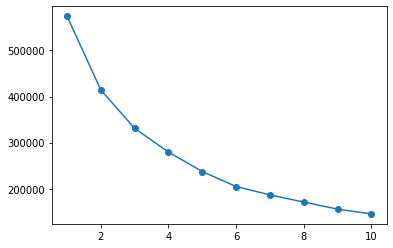

In [93]:
elbow(data_points)

In [94]:
kmeans = KMeans(n_clusters = 10).fit(data_points)

In [95]:
df_1['cluster_id'] = kmeans.labels_

In [96]:
df_1.head()

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,cluster_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,20,52,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,74,12,13,74,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,74,30,6
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,31,74,74,74,24,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,10,32,37,10,3,8


(array([ 5., 60.,  1., 10.,  1.,  7., 10.,  2., 18.,  6.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

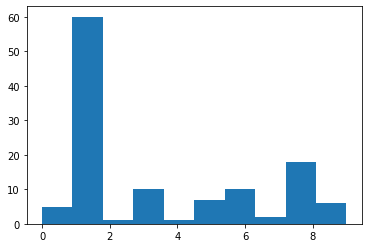

In [97]:
plt.hist(df_1['cluster_id'])

In [98]:
for j in range(10):
    print('-'*100)
    print(j)
    print('-'*100)

    for i in range(len(df)):
        if df_1['cluster_id'][i]==j:
            print(df['질문'][i])

----------------------------------------------------------------------------------------------------
0
----------------------------------------------------------------------------------------------------
곤충관에서는 곤충에게 먹이를 아침에 47봉지，점심에 69봉지를 주었습니다. 아침과 점심에 먹이를 모두 몇 봉지 주었을까요?
서경이는 공책을 몇 권 가지고 있습니다. 선물로 11권을 더 받아서 23권이 되었습니다. 􀓭 안에 알맞은 수를 써넣으시오.
경이는 흰 구슬 16개와 검은 구슬 18개를 가졌습니다. 경이가 가지고 있는 구슬은 모두 몇 개입니까?
철수와 영수는 28개의 사탕을 갖고 있습니다. 철수가 13개의 사탕을 갖고 있다면 영수가 갖고 있는 사탕은 몇 개인가요?
경호는 구슬을 48개 가지고 있고, 미영이는 8개 가지고 있습니다. 그리고 정은이는 7개를 가지고 있습니다. 세 사람이 가지고 있는 구슬은 모두 몇 개입니까?
----------------------------------------------------------------------------------------------------
1
----------------------------------------------------------------------------------------------------
준기는 동화책을 어제는 58쪽，오늘은 54쪽 읽었습니다. 준기는 어제와 오늘 동화책을 모두 몇 쪽 읽었을까요?
민지는 구슬을 5개 가지고 있고, 민영이는 구슬을 민지보다 3개 더 가지고 있습니다. 민영이가 가지고 있는 구슬은 몇 개입니까?
영희는 54개의 구슬을 가지고 있습니다. 철수가 영희에게 86개의 구슬을 더 주었습니다. 영희가 가진 구슬은 모두 몇 개입니까?
성진이는 구슬 6개를 가지고 있습니다. 민주가 성진이에게 구

## 3. 워드투벡터

In [28]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

In [29]:
# def plot_2d_greph(vocabs, xs, ys):
#     plt.figure(figsize=(8,6))
#     plt.scatter(xs, ys, marker = 'o')
#     for i, v in enumerate(vocabs):
#         plt.annotate(v, xy=(xs[i], ys[i]))

In [35]:
model = Word2Vec(sentences, size=300, window=3, min_count=1, workers=1)

**여기서 Word2Vec의 하이퍼파라미터값은 다음과 같습니다.**
* size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
* window = 컨텍스트 윈도우 크기
* min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
* workers = 학습을 위한 프로세스 수
* sg = 0은 CBOW, 1은 Skip-gram.

In [36]:
model_result=model.wv.most_similar("상자")
print(model_result)

[('읽었다면', 0.20815624296665192), ('풍선', 0.18937817215919495), ('에는', 0.18765544891357422), ('18', 0.18368718028068542), ('사탕', 0.1720675528049469), ('자루', 0.17181791365146637), ('614', 0.17070582509040833), ('나누어', 0.17010805010795593), ('451', 0.1546822041273117), ('나오겠습니까', 0.1505413055419922)]


### 결론 : 문장 하나하나가 짧아서 유사도에서 의미를 찾긴 어려워 보임